In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Libraries

In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer





# Load Datasets

In [ ]:
# 2. Load Datasets
flights = pd.read_csv("/content/drive/MyDrive/Masai /MASAI-PROJECTS/flights.csv")
airlines = pd.read_csv("/content/drive/MyDrive/Masai /MASAI-PROJECTS/airlines.csv")
airports = pd.read_csv("/content/drive/MyDrive/Masai /MASAI-PROJECTS/airports.csv")

print("Flights shape:", flights.shape)
print("Airlines shape:", airlines.shape)
print("Airports shape:", airports.shape)

# Inspect
print(flights.head())
print(airlines.head())
print(airports.head())

/tmp/ipython-input-3837961367.py:2: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  flights = pd.read_csv("/content/drive/MyDrive/Masai /MASAI-PROJECTS/flights.csv")


Flights shape: (5819079, 31)
Airlines shape: (14, 2)
Airports shape: (322, 7)
   YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4      AS             98      N407AS   
1  2015      1    1            4      AA           2336      N3KUAA   
2  2015      1    1            4      US            840      N171US   
3  2015      1    1            4      AA            258      N3HYAA   
4  2015      1    1            4      AS            135      N527AS   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  ...  ARRIVAL_TIME  \
0            ANC                 SEA                    5  ...         408.0   
1            LAX                 PBI                   10  ...         741.0   
2            SFO                 CLT                   20  ...         811.0   
3            LAX                 MIA                   20  ...         756.0   
4            SEA                 ANC                   25  ...         259.0   

   ARRIVAL_DEL

# Preprocessing

In [ ]:
# 3. Merge Airline Names
# Rename columns after first merge
flights.rename(columns={
    "AIRLINE_x": "AIRLINE_CODE",   # airline code from flights.csv
    "AIRLINE_y": "Airline_Name"    # full airline name from airlines.csv
}, inplace=True)

# Drop duplicate merge key
flights.drop(columns=["IATA_CODE"], inplace=True, errors="ignore")

# Merge Airport Info
flights = flights.merge(
    airports, left_on="ORIGIN_AIRPORT", right_on="IATA_CODE", how="left", suffixes=("", "_ORIGIN")
)
flights = flights.merge(
    airports, left_on="DESTINATION_AIRPORT", right_on="IATA_CODE", how="left", suffixes=("", "_DEST")
)


In [ ]:
# 4. Target Variable: Delayed (arrival delay > 15 min)
flights['Delayed'] = (flights['ARRIVAL_DELAY'] > 15).astype(int)



In [ ]:
# 5. Data Cleaning
# Drop irrelevant or high-cardinality text columns
flights.drop([
    'TAIL_NUMBER','FLIGHT_NUMBER','CANCELLATION_REASON',
    'DIVERTED','CANCELLED','IATA_CODE','IATA_CODE_DEST','Airline_Name',
    'CITY','STATE','COUNTRY','AIRPORT'
], axis=1, inplace=True, errors='ignore')

# Drop rows missing essential numeric columns
flights.dropna(subset=['ARRIVAL_DELAY','DISTANCE','DEPARTURE_TIME'], inplace=True)


# Feature Engineering

In [ ]:
# 6. Feature Engineering
flights['FL_DATE'] = pd.to_datetime(dict(year=flights.YEAR, month=flights.MONTH, day=flights.DAY))
flights['DayOfWeek'] = flights['DAY_OF_WEEK']
flights['Hour'] = (flights['SCHEDULED_DEPARTURE'] // 100).astype(int)

# Reduce high-cardinality airports → top 20, rest as OTHER
top_origins = flights['ORIGIN_AIRPORT'].value_counts().nlargest(20).index
top_dests = flights['DESTINATION_AIRPORT'].value_counts().nlargest(20).index

flights['ORIGIN_AIRPORT'] = flights['ORIGIN_AIRPORT'].where(flights['ORIGIN_AIRPORT'].isin(top_origins), 'OTHER')
flights['DESTINATION_AIRPORT'] = flights['DESTINATION_AIRPORT'].where(flights['DESTINATION_AIRPORT'].isin(top_dests), 'OTHER')


In [ ]:
# 7. One-hot encode categorical features
categorical = ['AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT']

# Only keep columns that exist (safety check)
categorical = [col for col in categorical if col in flights.columns]

# Convert categorical columns to numeric using one-hot encoding
flights = pd.get_dummies(flights, columns=categorical, drop_first=True)


In [ ]:
# Sample dataset to reduce memory usage
flights_sample = flights.sample(n=200000, random_state=42)
print("Sampled dataset shape:", flights_sample.shape)


Sampled dataset shape: (200000, 88)


In [ ]:
# 8. Features & Target
X = flights.drop(['ARRIVAL_DELAY','Delayed','FL_DATE','YEAR','MONTH','DAY','DAY_OF_WEEK','SCHEDULED_DEPARTURE'], axis=1, errors='ignore')
y = flights['Delayed']

# Keep only numeric columns
X = X.select_dtypes(include=np.number)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# 9. Handle missing values
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Replace any remaining NaNs with 0
X_train = np.nan_to_num(X_train, nan=0)
X_test = np.nan_to_num(X_test, nan=0)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Model Training and Evaluation

Accuracy: 0.9999
Recall: 0.9998
F1 Score: 0.9998
ROC-AUC: 1.0


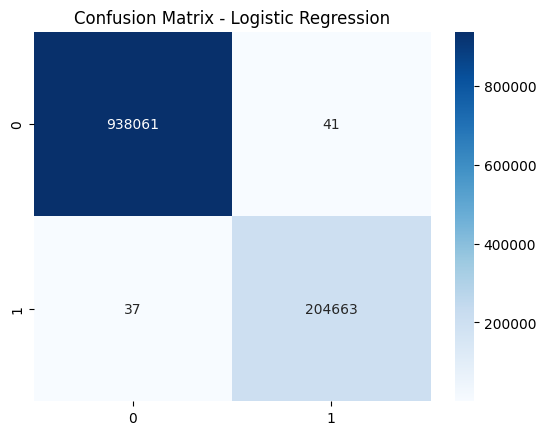

In [ ]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, lr_model.predict_proba(X_test)[:,1]), 4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


Accuracy: 0.994
Recall: 0.9997
F1 Score: 0.9834
ROC-AUC: 0.9998


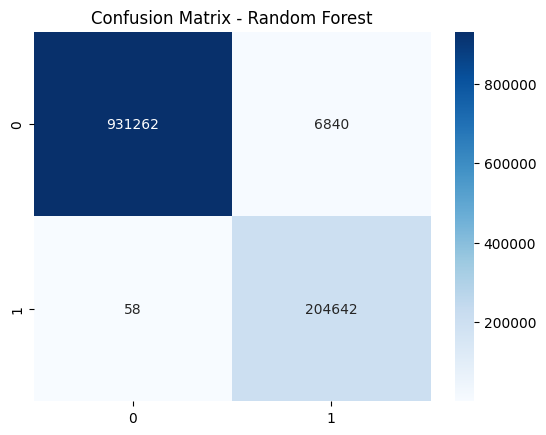

In [ ]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=10, max_depth=8, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1]), 4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:25:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9974
Recall: 0.9987
F1 Score: 0.9927
ROC-AUC: 0.9999


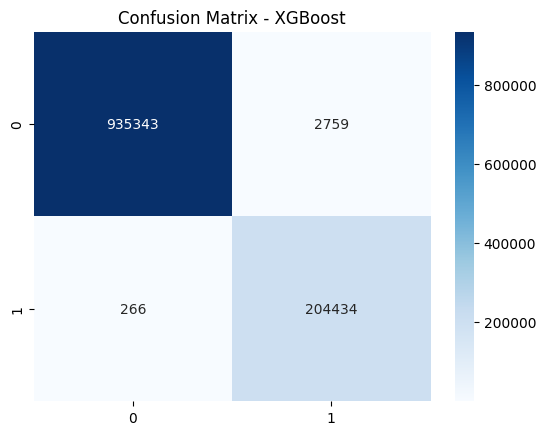

In [ ]:
# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=10)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1]), 4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.show()
